# PROJECT LAYOUT

#### The aim of this project is to analyse IPL matches data and distribute batsmen and bowlers into clusters according to their batting and bowling performances.

#### The dataset contains ball-by-ball match data in one csv file and a second csv file that contains the names of the cricketers.

# A. READING IN THE DATA

In [409]:
# Importing the libraries

import pandas as pd
import numpy as np

# Reading in the Data

runs = pd.read_csv("Ball_by_Ball.csv")
runs.head()

,Match_Id,Innings_Id,Over_Id,Ball_Id,Team_Batting_Id,Team_Bowling_Id,Striker_Id,Striker_Batting_Position,Non_Striker_Id,Bowler_Id,Batsman_Scored,Extra_Type,Extra_Runs,Player_dissimal_Id,Dissimal_Type,Fielder_Id
0,335987,1,1,1,1,2,1,1,2,14,0,legbyes,1,,,
1,335987,1,1,2,1,2,2,2,1,14,0,,,,,
2,335987,1,1,3,1,2,2,2,1,14,0,wides,1,,,
3,335987,1,1,4,1,2,2,2,1,14,0,,,,,
4,335987,1,1,5,1,2,2,2,1,14,0,,,,,


In [486]:
Players = pd.read_csv("Player.csv")
Players = Players[["Player_Id", "Player_Name"]]
Players.head()

,Player_Id,Player_Name
0,1,SC Ganguly
1,2,BB McCullum
2,3,RT Ponting
3,4,DJ Hussey
4,5,Mohammad Hafeez


In [410]:
# Keeping only relevant data for analysis.

runs = runs[["Match_Id", "Over_Id", "Striker_Id", "Bowler_Id", "Batsman_Scored", "Extra_Runs"]]
runs.head()

,Match_Id,Over_Id,Striker_Id,Bowler_Id,Batsman_Scored,Extra_Runs
0,335987,1,1,14,0,1
1,335987,1,2,14,0,
2,335987,1,2,14,0,1
3,335987,1,2,14,0,
4,335987,1,2,14,0,


#### From above, we can clearly see that Extra_Runs column contains null values. Checking for null values and data types.

In [411]:
runs.isnull().sum()

Match_Id          0
Over_Id           0
Striker_Id        0
Bowler_Id         0
Batsman_Scored    0
Extra_Runs        0
dtype: int64

In [412]:
# Since isnull gives no null values, checking for data types.

runs.dtypes

Match_Id           int64
Over_Id            int64
Striker_Id         int64
Bowler_Id          int64
Batsman_Scored    object
Extra_Runs        object
dtype: object

In [413]:
# Converting object columns into numeric.
# Replacing null values with 0 runs.

runs["Extra_Runs"] = pd.to_numeric(runs["Extra_Runs"], errors="coerce")
runs["Extra_Runs"] = runs["Extra_Runs"].fillna(0)

runs["Batsman_Scored"] = pd.to_numeric(runs["Batsman_Scored"], errors="coerce")
runs["Batsman_Scored"] = runs["Batsman_Scored"].fillna(0)
runs.head(14)

,Match_Id,Over_Id,Striker_Id,Bowler_Id,Batsman_Scored,Extra_Runs
0,335987,1,1,14,0.0,1.0
1,335987,1,2,14,0.0,0.0
2,335987,1,2,14,0.0,1.0
3,335987,1,2,14,0.0,0.0
4,335987,1,2,14,0.0,0.0
5,335987,1,2,14,0.0,0.0
6,335987,1,2,14,0.0,1.0
7,335987,2,2,15,0.0,0.0
8,335987,2,2,15,4.0,0.0
9,335987,2,2,15,4.0,0.0


# B. Creating a DF for Batsmen

In [414]:
# To analyse the strike rate of a bastman, we need runs scored by him and the number of balls he faced.
# The strike rate for the batsman can be calculated from these two values.

A = []
B = []

for i in runs["Striker_Id"].unique():
    a = runs["Batsman_Scored"][runs["Striker_Id"] == i].sum()
    b = runs["Match_Id"][runs["Striker_Id"] == i].count()
    A.append(a)
    B.append(b)

Batsmen = pd.DataFrame({"Player_names": runs["Striker_Id"].unique()})

Batsmen["Runs"] = A
Batsmen["Balls_played"] = B

# Calculating strike rate using the formula (strike_rate = runs per 100 balls faced)

Batsmen["Strike_Rate"] = (Batsmen["Runs"] * 100 / Batsmen["Balls_played"]).round(2)

# Since we have to assess batsmen, the players with very low strike rates are not required to be considered
# as they tend to bat very few times and are usually bowlers/fielders.

Batsmen = Batsmen[Batsmen["Strike_Rate"] > 60]
Batsmen = Batsmen[Batsmen["Strike_Rate"] < 150]

# Applying another filtering - run rate, which is equal to runs per over(or per 6 balls).

Batsmen = Batsmen[(Batsmen["Runs"]*6/Batsmen["Balls_played"]) > 6]

Batsmen.head()

,Player_names,Runs,Balls_played,Strike_Rate
0,1,1349.0,1326,101.73
1,2,2435.0,1954,124.62
3,4,1322.0,1101,120.07
5,6,2170.0,1918,113.14
6,7,130.0,129,100.78


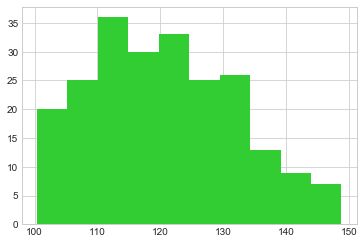

In [416]:
# Checking the distribution of batsmen by plotting a histogram.

Batsmen["Strike_Rate"].hist(color="limegreen")

# C. APPLYING K MEANS ALGORITHM ON BATSMEN DATA

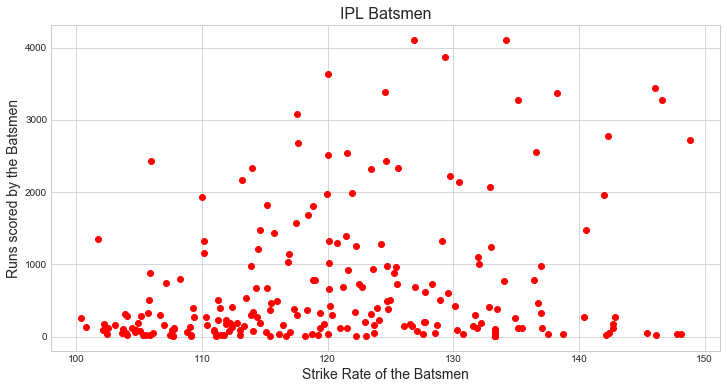

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

fig = plt.figure(figsize=(12,6))
plt.scatter(Batsmen["Strike_Rate"], Batsmen["Runs"], color="red")
plt.xlabel("Strike Rate of the Batsmen", fontsize=14)
plt.ylabel("Runs scored by the Batsmen", fontsize=14)
plt.title("IPL Batsmen", fontsize=16)
plt.show()

#### The distribution of the Batsmen appears to be in largely five clusters:
#### under 500 runs - highest density of dots
#### 500 - 1000 runs
#### 1000 - 2000 runs
#### 2000 - 3000 runs
#### above 3000 runs

### Applying the clustering algorithm

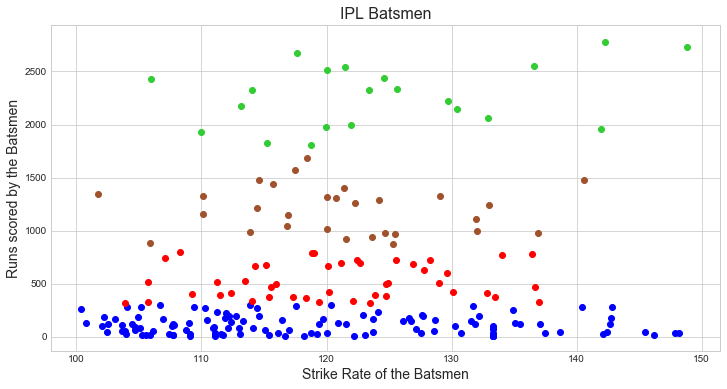

In [590]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(Batsmen[["Strike_Rate", "Runs"]])
Batsmen["cluster"] = kmeans.labels_

fig = plt.figure(figsize=(12,6))

colors = ["blue", "sienna", "limegreen", "red", "indigo"]

for r in range(1,6):
    clustered_Batsmen = Batsmen[Batsmen["cluster"] == r]
    plt.scatter(clustered_Batsmen["Strike_Rate"], clustered_Batsmen["Runs"], color=colors[r-1])
    
plt.title("IPL Batsmen", fontsize=16)
plt.xlabel("Strike Rate of the Batsmen", fontsize=14)
plt.ylabel("Runs scored by the Batsmen", fontsize=14)
    
plt.show()

### Merging the Player DF and Batsmen DF to show player names and cluster ids.

In [488]:
Batsmen = Batsmen.rename(columns={"Player_names": "Player_Id"})

Batsmen = Batsmen[Batsmen.columns].merge(Players, "left")
Batsmen.head()

,Player_Id,Runs,Balls_played,Strike_Rate,cluster,Player_Name
0,1,1349.0,1326,101.73,2,SC Ganguly
1,2,2435.0,1954,124.62,0,BB McCullum
2,4,1322.0,1101,120.07,2,DJ Hussey
3,6,2170.0,1918,113.14,0,R Dravid
4,7,130.0,129,100.78,4,W Jaffer


# D. CREATING A DF FOR BOWLER DATA

In [388]:
# To analyse the performance of a bowler, we need runs conceded by him and the number of overs he bowled.
# The economy rate of the bowler, thus, can be calculated from these two values.

# Repeating the process as in the Batsmen dataframe creation.

C = []
E = []

for j in runs["Bowler_Id"].unique():
    c = runs["Batsman_Scored"][runs["Bowler_Id"] == j].sum() + runs["Extra_Runs"][runs["Bowler_Id"] == j].sum()
    
    e = runs["Over_Id"][runs["Bowler_Id"] == j].count()/6
    
    C.append(c)
    E.append(e)
    
Bowlers = pd.DataFrame({"Bowler_names": runs["Bowler_Id"].unique()})

Bowlers["Runs"] = C
Bowlers["Over_count"] = E

# Economy rate can be calculated by dividing the total runs conceded by the number of overs bowled.

Bowlers["Econ_Rate"] = (Bowlers["Runs"] / Bowlers["Over_count"]).round(2)

Bowlers.head()

,Bowler_names,Runs,Over_count,Econ_Rate
0,14,3135.0,421.500000,7.44
1,15,2511.0,338.333333,7.42
2,13,41.0,4.166667,9.84
3,9,2316.0,299.833333,7.72
4,16,82.0,9.166667,8.95


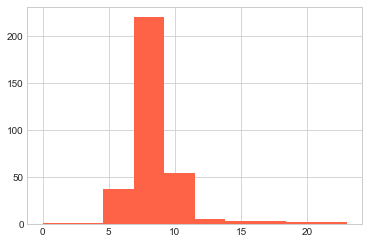

In [373]:
# Checking the distribution of batsmen by plotting a histogram.

Bowlers["Econ_Rate"].hist(color="tomato")

In [503]:
# There is no need to cluster the players below economy rate of 4 as they are the star bowlers.
# Similarly, bowlers with economy rates above 12.5 are not likely to be good candidates for bowling.
# They are most likely batsmen, and thus, they too can be excluded.

Bowlers = Bowlers[(Bowlers["Econ_Rate"] > 4) & (Bowlers["Econ_Rate"] < 10.5)]

# E. APPLYING K MEANS ALGORITHM ON BOWLER DATA

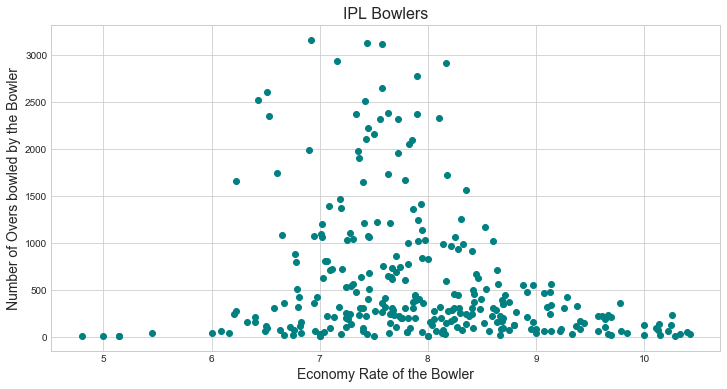

In [504]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(12,6))
plt.scatter(Bowlers["Econ_Rate"], Bowlers["Runs"], color="teal")
plt.xlabel("Economy Rate of the Bowler", fontsize=14)
plt.ylabel("Number of Overs bowled by the Bowler", fontsize=14)
plt.title("IPL Bowlers", fontsize=16)
plt.show()

#### The distribution appears to be largely in 5 clusters again:
#### With runs under 500
#### With runs under 500 - 1000
#### With runs under 1000 - 1500
#### With runs under 1500 - 2000
#### With runs above 2000

### Applying the clustering algorithm

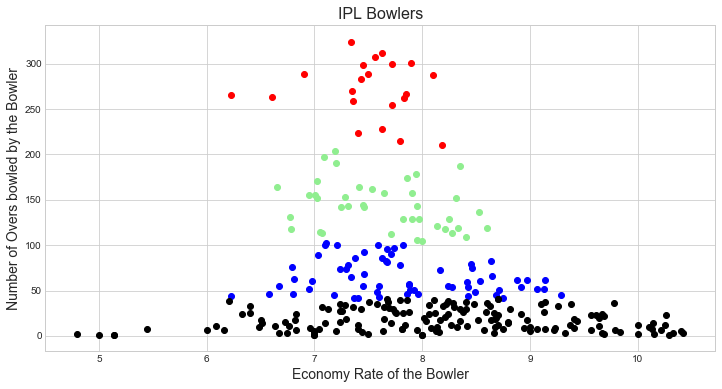

In [533]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(Bowlers[["Econ_Rate", "Over_count"]])
Bowlers["cluster"] = kmeans.labels_

fig = plt.figure(figsize=(12,6))

colors = ["blue", "lightgreen", "black", "red"]

for r in range(1,5):
    clustered_Bowlers = Bowlers[Bowlers["cluster"] == r]
    plt.scatter(clustered_Bowlers["Econ_Rate"], clustered_Bowlers["Over_count"], color=colors[r-1])
    
plt.title("IPL Bowlers", fontsize=16)
plt.xlabel("Economy Rate of the Bowler", fontsize=14)
plt.ylabel("Number of Overs bowled by the Bowler", fontsize=14)
    
plt.show()

### Merging the Player DF and Batsmen DF to show player names and cluster ids.

In [534]:
Bowlers = Bowlers.rename(columns={"Bowler_names": "Player_Id"})
Bowlers.head()

,Player_Id,Runs,Over_count,Econ_Rate,Player_Name,cluster
0,14,3135.0,421.500000,7.44,P Kumar,0
1,15,2511.0,338.333333,7.42,Z Khan,0
2,13,41.0,4.166667,9.84,AA Noffke,3
3,9,2316.0,299.833333,7.72,JH Kallis,4
4,16,82.0,9.166667,8.95,SB Joshi,3


In [535]:
Bowlers = Bowlers[Bowlers.columns].merge(Players, "left")
Bowlers.head()

,Player_Id,Runs,Over_count,Econ_Rate,Player_Name,cluster
0,14,3135.0,421.500000,7.44,P Kumar,0
1,15,2511.0,338.333333,7.42,Z Khan,0
2,13,41.0,4.166667,9.84,AA Noffke,3
3,9,2316.0,299.833333,7.72,JH Kallis,4
4,16,82.0,9.166667,8.95,SB Joshi,3


## Thus, batsmen and bowlers have been clustered as per their performance
## of the many IPL seasons!